_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [32]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [33]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [34]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [35]:
train['Violations']

0        3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...
1        32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...
2        35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...
3        38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...
4        34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
                               ...                        
51911                                                  NaN
51912                                                  NaN
51913    33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
51914                                                  NaN
51915    33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
Name: Violations, Length: 51916, dtype: object

In [36]:
# train = train[train['Facility Type'].notnull()]
# train = train[train['Risk'].notnull()]
# train = train[train['AKA Name'].notnull()]

In [37]:
from sklearn.model_selection import train_test_split


In [38]:

train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)


In [39]:
# Chose features based on line 50 feature importances

target = 'Fail'
features = ['Facility Type', 'Risk', 'Longitude', 'Address', 'Location', 'Latitude', 'AKA Name','State', 'City','Violations','Inspection Type', 'Inspection ID', "Inspection Date", "License #"]
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


In [40]:
# Baseline: 74%

y_train.value_counts(normalize=True)

0    0.743764
1    0.256236
Name: Fail, dtype: float64

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [41]:
# Installing eli5

pip install eli5

SyntaxError: invalid syntax (<ipython-input-41-d48727f399fc>, line 3)

In [42]:
# Importing necessary tools

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import r2_score
from xgboost import XGBRegressor


In [43]:
# Creating pipeline for RFC

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [44]:
# Fitting pipeline on train set

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk', 'Address',
                                      'Location', 'AKA Name', 'State', 'City',
                                      'Violations', 'Inspection Type',
                                      'Inspection Date'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Restaurant                           1
Bakery                               2
Daycare Above and Und...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_fe

In [45]:
#Score for val set

pipeline.score(X_val, y_val)

0.7291987673343605

In [46]:
#Score for test set

pipeline.score(X_test, y_test)

0.7381255056049925

In [47]:
#Pred proba/ROC AUC for val set

y_pred_proba = pipeline.predict_proba(X_val)[:, -1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc_score(y_val, y_pred_proba)

0.6099456244328493

In [48]:
#Pred proba/ROC AUC for test set

y_test_proba = pipeline.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc_score(y_test, y_test_proba)

0.6262834641486728

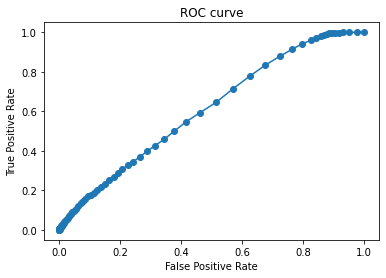

In [49]:
# ROC AUC Visualization

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]
roc_auc_score(y_val, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})


import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

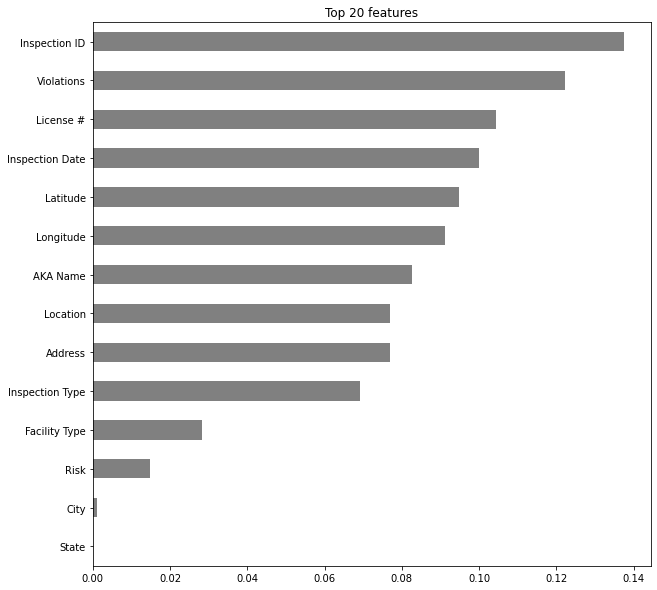

In [50]:
# Feature importances visualization

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [51]:
# Fitting RFC model


transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median') 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [52]:
# Fitting permutation importances 

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [53]:
# Looking at permutation importance list

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Location          -0.001233
Longitude         -0.001002
Risk              -0.000905
AKA Name          -0.000713
Address           -0.000693
State              0.000000
City               0.000019
Violations         0.000058
Inspection Date    0.000154
Latitude           0.000270
License #          0.000674
Facility Type      0.000924
Inspection ID      0.001637
Inspection Type    0.005027
dtype: float64

In [54]:
# Permutation importances visualization

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0050 ± 0.0019,Inspection Type
0.0016 ± 0.0018,Inspection ID
0.0009 ± 0.0007,Facility Type
0.0007 ± 0.0014,License #
0.0003 ± 0.0020,Latitude
0.0002 ± 0.0017,Inspection Date
0.0001 ± 0.0007,Violations
0.0000 ± 0.0001,City
0 ± 0.0000,State
-0.0007 ± 0.0010,Address


In [55]:
# Fitting xgb model

gb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.07472421044915101


In [56]:
# Partial Dependence Plot, 1 feature isolation

feature = 'Inspection ID'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    num_grid_points=50,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x27f2ff7b088>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x27f2dbada08>})

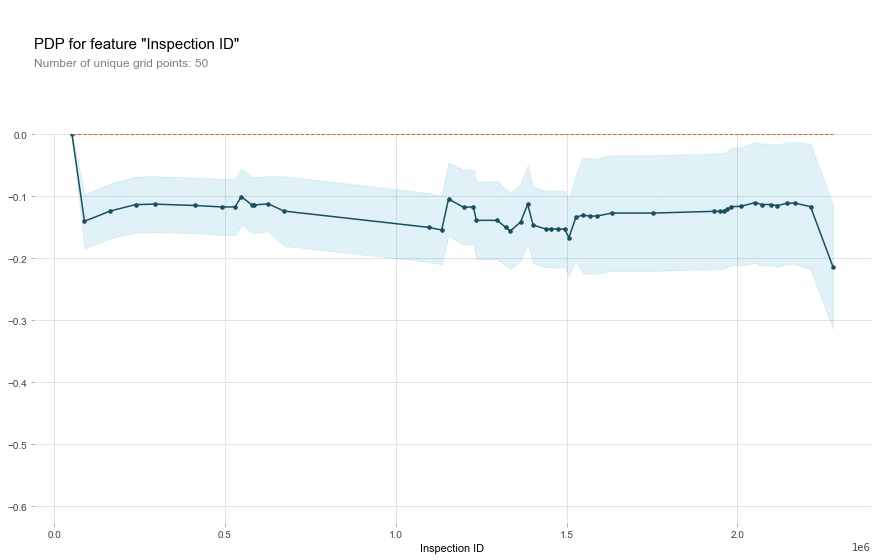

In [57]:
pdp_plot(isolated, feature_name=feature)